## Análise: Anúncios com endereço incompleto possuem um melhor desempenho?

In [977]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [978]:
#bases
listings = pd.read_csv ("listings.csv", sep=",").fillna("")
leads = pd.read_csv ("leads.csv", sep = ",", index_col= "listing_id")

In [979]:
#Inclusão da coluna com leads
listings ['leads'] = listings.listing_id.map (leads.leads)
listings = listings.fillna(0)
#colunas de data
listings.snapshot_date = pd.to_datetime (listings.snapshot_date)
listings.created_date = pd.to_datetime (listings.created_date).astype('datetime64[D]')

In [980]:
#Inclusão da coluna status_end
ref = []
for i, j, k in zip (listings.street, listings.CEP, listings.street_number):
    if i != "" and j != "" and k != "":
        ref.append ("Completo")
    else:
        ref.append("Incompleto")
listings ["status_end"] = ref
#listings.head(0)

In [981]:
#Qtde de leads de anúncios com e sem endereço completo

#Todos os anúncios 
leads_por_anuncio_todos_os_anuncios =\
            listings [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',values=['listing_id', 'leads'],
                          aggfunc= {'listing_id': 'count', 'leads': 'sum'},
                         margins=True, margins_name= "Total")\
            .reset_index()
    
leads_por_anuncio_todos_os_anuncios ['% leads'] = leads_por_anuncio_todos_os_anuncios.leads / leads_por_anuncio_todos_os_anuncios.leads.iloc [-1] * 100
leads_por_anuncio_todos_os_anuncios ['% listing id'] = leads_por_anuncio_todos_os_anuncios.listing_id / leads_por_anuncio_todos_os_anuncios.listing_id.iloc [-1] * 100

#Somente anúncios com leads
table1 = listings [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',
                          values=['listing_id', 'leads'],
                          aggfunc= np.count_nonzero, margins=True, margins_name="Total")\
            .reset_index()

table1 ['% c/ lead'] = (table1.leads / table1.listing_id ) * 100

leads_por_anuncio_todos_os_anuncios = pd.concat ([leads_por_anuncio_todos_os_anuncios, table1[['leads', '% c/ lead']]], axis=1).set_index('status_end')
leads_por_anuncio_todos_os_anuncios.columns = ['sum_leads', 'listing_id', '%_leads', '%_listing_id', 'com_leads', '%_c/_leads']
leads_por_anuncio_todos_os_anuncios ['leads_por_anuncio'] = leads_por_anuncio_todos_os_anuncios.sum_leads / leads_por_anuncio_todos_os_anuncios.com_leads
leads_por_anuncio_todos_os_anuncios [['listing_id', '%_listing_id', 'com_leads', '%_c/_leads', 'sum_leads', '%_leads', 'leads_por_anuncio']]\
    .round(1)\
    .T\
    .style.set_caption ("Quantidade de anúncios, quantidade de leads\
                        e leads por anúncio - aberto por status_end (tabela 1)")

status_end,Completo,Incompleto,Total
listing_id,160322,82303,242625
%_listing_id,66.1,33.9,100
com_leads,16420,5540,21960
%_c/_leads,10.2,6.7,9.1
sum_leads,44793,14077,58870
%_leads,76.1,23.9,100
leads_por_anuncio,2.7,2.5,2.7


##### Observações iniciais (tabela1):

- Do total de anúncios da base, apenas 9% tiveram algum lead (baixo número de anúncios com algum lead).
- Mais de 65% do total de anúncios estão com rua, CEP e número, portanto, estão com endereço completo.
   - Destes 65%, apenas 10% tiveram algum lead.


- Quase 35% dos anúncios estão com endereço incompleto.
    - Destes quase 35%, menos de 7% tiveram algum lead.
    
    
- Quando olhamos para a quantidade de lead por anúncio (apenas dos anúncios que tiveram algum lead), vemos que os anúncios com endereço completo têm um desempenho melhor. O grupo de anúncios com endereço completo não tem apenas mais anúncios com algum lead como também tem mais leads por anúncio (+8%).

<font color="green"> Já é um primeiro sinal de que os anúncios com endereço completo recebem mais leads, contrariando a hipótese levantada.
    
<font color="purple">  Mas é preciso analisar com mais profundidade:
    

In [982]:
ref=[]
for i in listings.leads:
    if i == 0:
        ref.append ("0")
    elif i < 5:
        ref.append ("até 05")
    elif i < 10:
        ref.append ("até 10")
    elif i < 20:
        ref.append ("até 20")
    else:
        ref.append("maior que 20")
listings ['status_lead'] = ref

qtde_de_anuncios_por_faixa_de_leads =\
            listings[(listings.status_lead != "0") & (listings.city != '')]\
            .pivot_table(index= 'status_lead', values= 'listing_id',
                         aggfunc= {'listing_id': 'count'},
                         columns = 'status_end',
                        margins=True, margins_name= 'Total')\
            .astype('int64')

qtde_de_anuncios_por_faixa_de_leads ["% Comp."] = qtde_de_anuncios_por_faixa_de_leads.Completo / qtde_de_anuncios_por_faixa_de_leads.Completo.iloc [-1] * 100
qtde_de_anuncios_por_faixa_de_leads ["% Incomp."] = qtde_de_anuncios_por_faixa_de_leads.Incompleto / qtde_de_anuncios_por_faixa_de_leads.Incompleto.iloc [-1] * 100
qtde_de_anuncios_por_faixa_de_leads ["% Total."] = qtde_de_anuncios_por_faixa_de_leads.Total / qtde_de_anuncios_por_faixa_de_leads.Total.iloc [-1] * 100


qtde_de_anuncios_por_faixa_de_leads [['Completo', '% Comp.', 'Incompleto', '% Incomp.', 'Total', '% Total.']]\
            .astype ('int64')\
            .style.set_caption ("Quantidade de anúncios por faixa de leads\
                                - aberto por status_end (tabela2)")

status_end,Completo,% Comp.,Incompleto,% Incomp.,Total,% Total.
status_lead,,,,,,
até 05,14207,86,4904,88,19111,87
até 10,1497,9,435,7,1932,8
até 20,528,3,146,2,674,3
maior que 20,188,1,55,0,243,1
Total,16420,100,5540,100,21960,100


##### observações (tabela2) :

- Com o objetivo de evitar o efeito de outliers, separei os anúncios por faixas de quantidade de leads:
    - 86% dos anúncios com endereço completo tiveram até 5 leads, enquanto que 88% dos anúncios com endereço incompleto tiveram ate 5 leads.
    - Depois da primeira faixa (até 05), a medida que a quantidade de leads aumenta (até 10, até 20, etc.), a proporção de anúncios com endereço incompleto é menor do que a de anúncios com endereço completo. 
    - Ou seja, a concentração de anúncios com pouco lead é maior nos anúncios com endereço incompleto.
    
<font color="green"> O gráfico abaixo representa esta relação.

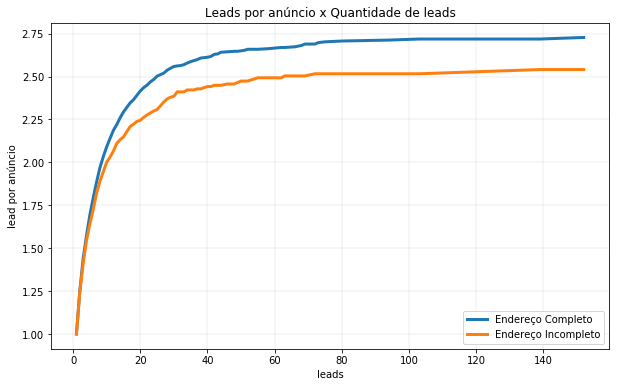

In [983]:
graf1 = listings[(listings.status_lead != "0") & (listings.city != '')]\
            .pivot_table(index= 'leads', values= 'listing_id',
                         aggfunc= {'listing_id': 'count'},
                        columns='status_end').reset_index()
graf1 ["Completox"] = graf1.leads * graf1.Completo
graf1 ["Incompletox"] = graf1.leads * graf1.Incompleto

ref1=[]
ref2=[]
b = 1
while b <= len(graf1.leads):
    i = graf1.Completox.iloc [0:b].sum() / graf1.Completo.iloc [0:b].sum()
    j = graf1.Incompletox.iloc [0:b].sum() / graf1.Incompleto.iloc [0:b].sum()
    ref1.append (i)
    ref2.append (j)
    b= b+1
graf1 ['lead_por_anúncio_Completo'] = ref1
graf1 ['lead_por_anúncio_Incompleto'] = ref2

plt.figure (figsize=[10,6])
sns.lineplot (data=graf1, x='leads', y='lead_por_anúncio_Completo',  lw=3, markers=True)
sns.lineplot (data=graf1, x='leads', y='lead_por_anúncio_Incompleto', lw=3, markers=True)
plt.legend(["Endereço Completo", "Endereço Incompleto"])
plt.title ("Leads por anúncio x Quantidade de leads")
plt.ylabel ("lead por anúncio")
plt.grid(linewidth=0.2)
#plt.xlim(0,35)

- A medida em que a quantidade de leads aumenta, vemos que a distância entre as duas curvas aumenta. O resultado fnal é que os anúncios com endereço completo tem um desempenho melhor.
- Se filtrássemos na base apenas os anúncios que tiveram até 20 leads, os anúncios com endereço completo teriam melhor desempenho. O mesmo acontece nos casos até 30 leads, 40 leads, etc.


#### Desempenho aberto por Portal

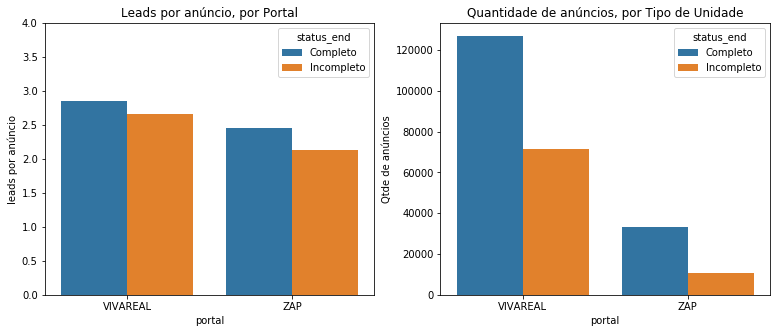

In [984]:
leads_por_anuncio_por_portal =\
            listings[listings.status_lead != "0"]\
            .pivot_table(index= ['status_end','portal'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'})

graf1 = round (leads_por_anuncio_por_portal.leads / leads_por_anuncio_por_portal.listing_id, 2).reset_index()
graf2 = listings [listings.leads > -1].pivot_table (index=['status_end','portal'], values='leads', aggfunc='count').reset_index()

plt.figure (figsize=[13,5])

plt.subplot(121)
sns.barplot(data=graf1, x='portal', y=0, hue='status_end')
plt.xticks (rotation = 'horizontal')
plt.ylim (0,4)
plt.ylabel ('leads por anúncio')
plt.title ('Leads por anúncio, por Portal')

plt.subplot(122)
sns.barplot(data=graf2, x='portal', y='leads', hue= 'status_end',  )
plt.xticks (rotation = 'horizontal')
plt.ylabel ('Qtde de anúncios')
plt.title ('Quantidade de anúncios, por Tipo de Unidade');


#listings.pivot_table (index='portal', values= ['leads', 'listing_id'], 
#                      aggfunc= {'leads': [ np.count_nonzero, 'sum'], 'listing_id': 'count' })

- Observa-se que o portal VIVA REAL tem uma captura maior de leads por anúncio do que o portal ZAP (graf1), mas é também o portal com mais anúncios (graf2).
- De todo modo, em ambos os portais para ocorrer o mesmo fenômeno identificado anteriormente, ou seja, que os anúncios com endereço completo têm um desempenho melhor.

#### Aberto por Cidade

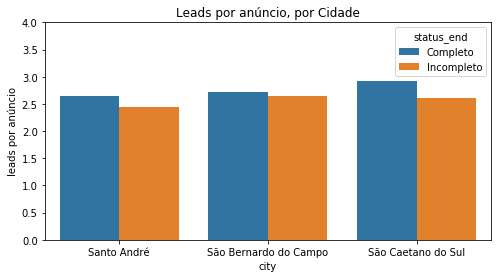

In [985]:
leads_por_anuncio_por_cidade =\
            listings[listings.status_lead != "0"]\
            .pivot_table(index= ['city', 'status_end'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'})

graf1 = round (leads_por_anuncio_por_cidade.leads / leads_por_anuncio_por_cidade.listing_id, 2).reset_index()

plt.figure (figsize=[8,4])
sns.barplot (data=graf1,  x='city', y=0, hue='status_end')
plt.xticks (rotation = 'horizontal')
plt.ylim (0,4)
plt.ylabel ('leads por anúncio')
plt.title ('Leads por anúncio, por Cidade');

- Os anúncios com endereço completo mantêm melhor desempenho quando aberto por cidade, apesar de São Bernado do Campo apresentar um diferença pequena.

#### Aberto por tipo de unidade

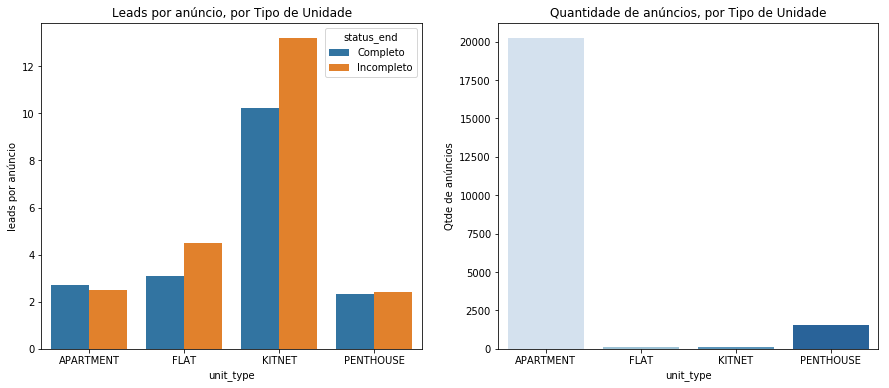

In [986]:
leads_por_anuncio_por_tipo_unid =\
            listings[(listings.status_lead != "0") & (listings.leads > 0)]\
            .pivot_table(index= ['unit_type', 'status_end'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'})

graf1 = round (leads_por_anuncio_por_tipo_unid.leads / leads_por_anuncio_por_tipo_unid.listing_id, 2).reset_index()
graf2 = listings.pivot_table (index='unit_type', values= ['leads'], aggfunc= np.count_nonzero)

plt.figure (figsize=[15,6])

plt.subplot(121)
sns.barplot (x= 'unit_type', y= 0, data= graf1, hue= 'status_end')
plt.xticks (rotation = 'horizontal')
plt.ylabel ('leads por anúncio')
plt.title ('Leads por anúncio, por Tipo de Unidade')

plt.subplot(122)
sns.barplot ( x=graf2.index, y= 'leads', data= graf2, palette='Blues')
plt.xticks (rotation = 'horizontal')
plt.ylabel ('Qtde de anúncios')
plt.title ('Quantidade de anúncios, por Tipo de Unidade');


- Aberto por tipo de unidade, vemos que apenas no tipo APARTAMENTO os anúncios com endereço completo têm perfomance melhor (graf. 1), e como este tipo tem maior representatividade sobre o total de anúncios (graf.2), este tipo influencia  bastante o desempenho geral. 

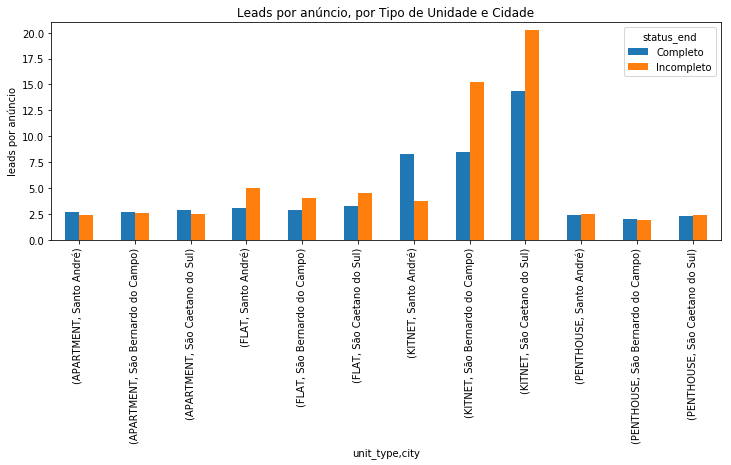

In [987]:
leads_por_anuncio_por_tipo_unid_e_cidade =\
            listings[listings.status_lead != "0"]\
            .pivot_table(index= ['unit_type', 'city'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'},
                         columns = 'status_end')

round (leads_por_anuncio_por_tipo_unid_e_cidade.leads / leads_por_anuncio_por_tipo_unid_e_cidade.listing_id, 2).plot(kind='bar', figsize= [12,4])
plt.xticks (rotation = 'vertical')
plt.ylim (0,21)
plt.ylabel ('leads por anúncio')
plt.title ('Leads por anúncio, por Tipo de Unidade e Cidade');

- A cidade de Santo André tem um resultado diferente das demais cidades no caso do tipo KITNET. Porém, os anúncios com endereço incompleto ainda mantém melhor performance.
- Porém, é necessário ainda aprofundar mais um pouco para verificar se o resultado não está distorcido devido a outliers (no caso de FLAT, KITET e PENTHOUSE).

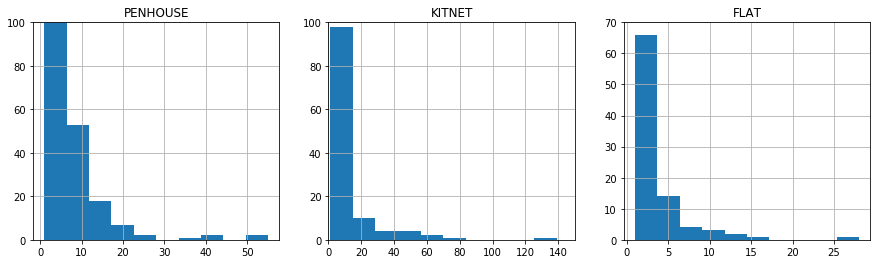

In [1010]:
fig, (ax1, ax2, ax3) = plt.subplots (1,3, figsize=[15,4])

listings[(listings.status_lead != "0") & (listings.unit_type == 'PENTHOUSE')]['leads'].hist(ax=ax1)
listings[(listings.status_lead != "0") & (listings.unit_type == 'KITNET')]['leads'].hist(ax=ax2)
listings[(listings.status_lead != "0") & (listings.unit_type == 'FLAT')]['leads'].hist(ax=ax3)

ax1.set_ylim (0,100) # vai até cerca de 1400
ax1.set_title ('PENHOUSE')

ax2.set_ylim (0,100)
ax2.set_xlim (0,150)
ax2.set_title ('KITNET')

ax3.set_ylim (0,70)
ax3.set_title ('FLAT');

- Ao plotar os histogramas, vemos que nos três casos há outliers.
- Abaixo, a quantidade de leads por anúncio (y) por total de anúncios no acumulado (x)

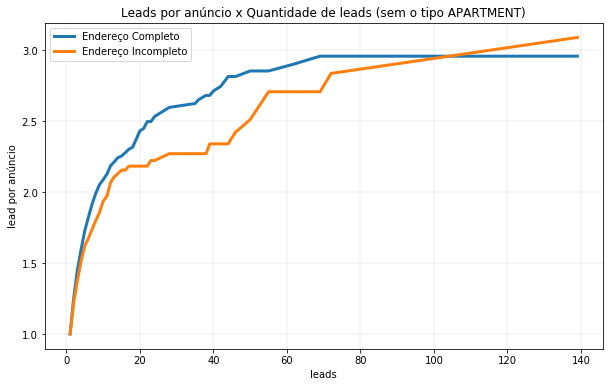

In [989]:
graf1 = listings[(listings.status_lead != "0") & (listings.unit_type != 'APARTMENT')]\
            .pivot_table(index= 'leads', values= 'listing_id',
                         aggfunc= {'listing_id': 'count'},
                        columns='status_end').reset_index()
graf1 ["Completox"] = graf1.leads * graf1.Completo
graf1 ["Incompletox"] = graf1.leads * graf1.Incompleto

ref1=[]
ref2=[]
b = 1
while b <= len(graf1.leads):
    i = graf1.Completox.iloc [0:b].sum() / graf1.Completo.iloc [0:b].sum()
    j = graf1.Incompletox.iloc [0:b].sum() / graf1.Incompleto.iloc [0:b].sum()
    ref1.append (i)
    ref2.append (j)
    b= b+1
graf1 ['lead_por_anúncio_Completo'] = ref1
graf1 ['lead_por_anúncio_Incompleto'] = ref2

plt.figure (figsize=[10,6])
sns.lineplot (data=graf1, x='leads', y='lead_por_anúncio_Completo',  lw=3, markers=True)
sns.lineplot (data=graf1, x='leads', y='lead_por_anúncio_Incompleto', lw=3, markers=True)
plt.legend(["Endereço Completo", "Endereço Incompleto"])
plt.title ("Leads por anúncio x Quantidade de leads (sem o tipo APARTMENT)")
plt.ylabel ("lead por anúncio")
plt.grid(linewidth=0.2)
#plt.xlim(0,35)

#### Grau de exibição do endereço

In [990]:
#Qtde de leads de anúncios com e sem endereço completo

#Todos os anúncios
listings_STREET = listings [listings.display_address_type == "STREET"]

leads_por_anuncio_todos_os_anuncios =\
            listings_STREET [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',values=['listing_id', 'leads'],
                          aggfunc= {'listing_id': 'count', 'leads': 'sum'},
                         margins=True, margins_name= "Total")\
            .reset_index()
    
leads_por_anuncio_todos_os_anuncios ['% leads'] = leads_por_anuncio_todos_os_anuncios.leads / leads_por_anuncio_todos_os_anuncios.leads.iloc [-1] * 100
leads_por_anuncio_todos_os_anuncios ['% listing id'] = leads_por_anuncio_todos_os_anuncios.listing_id / leads_por_anuncio_todos_os_anuncios.listing_id.iloc [-1] * 100

#Somente anúncios com leads
table1 = listings_STREET [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',
                          values=['listing_id', 'leads'],
                          aggfunc= np.count_nonzero, margins=True, margins_name="Total")\
            .reset_index()

table1 ['% c/ lead'] = (table1.leads / table1.listing_id ) * 100

leads_por_anuncio_todos_os_anuncios = pd.concat ([leads_por_anuncio_todos_os_anuncios, table1[['leads', '% c/ lead']]], axis=1).set_index('status_end')
leads_por_anuncio_todos_os_anuncios.columns = ['sum_leads', 'listing_id', '%_leads', '%_listing_id', 'com_leads', '%_c/_leads']
leads_por_anuncio_todos_os_anuncios ['leads_por_anuncio'] = leads_por_anuncio_todos_os_anuncios.sum_leads / leads_por_anuncio_todos_os_anuncios.com_leads
leads_por_anuncio_todos_os_anuncios [['listing_id', '%_listing_id', 'com_leads', '%_c/_leads', 'sum_leads', '%_leads', 'leads_por_anuncio']]\
    .round(1)\
    .T\
    .style.set_caption ("Quantidade de anúncios, quantidade de leads\
                        e leads por anúncio - aberto por status_end (STREET)")

status_end,Completo,Incompleto,Total
listing_id,98347,20367,118714
%_listing_id,82.8,17.2,100
com_leads,9411,1873,11284
%_c/_leads,9.6,9.2,9.5
sum_leads,23402,4113,27515
%_leads,85.1,14.9,100
leads_por_anuncio,2.5,2.2,2.4


In [991]:
#Qtde de leads de anúncios com e sem endereço completo

#Todos os anúncios
listings_NEIGBORHOOD = listings [listings.display_address_type == "NEIGHBORHOOD"]

leads_por_anuncio_todos_os_anuncios =\
            listings_NEIGBORHOOD [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',values=['listing_id', 'leads'],
                          aggfunc= {'listing_id': 'count', 'leads': 'sum'},
                         margins=True, margins_name= "Total")\
            .reset_index()
    
leads_por_anuncio_todos_os_anuncios ['% leads'] = leads_por_anuncio_todos_os_anuncios.leads / leads_por_anuncio_todos_os_anuncios.leads.iloc [-1] * 100
leads_por_anuncio_todos_os_anuncios ['% listing id'] = leads_por_anuncio_todos_os_anuncios.listing_id / leads_por_anuncio_todos_os_anuncios.listing_id.iloc [-1] * 100

#Somente anúncios com leads
table1 = listings_NEIGBORHOOD [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',
                          values=['listing_id', 'leads'],
                          aggfunc= np.count_nonzero, margins=True, margins_name="Total")\
            .reset_index()

table1 ['% c/ lead'] = (table1.leads / table1.listing_id ) * 100

leads_por_anuncio_todos_os_anuncios = pd.concat ([leads_por_anuncio_todos_os_anuncios, table1[['leads', '% c/ lead']]], axis=1).set_index('status_end')
leads_por_anuncio_todos_os_anuncios.columns = ['sum_leads', 'listing_id', '%_leads', '%_listing_id', 'com_leads', '%_c/_leads']
leads_por_anuncio_todos_os_anuncios ['leads_por_anuncio'] = leads_por_anuncio_todos_os_anuncios.sum_leads / leads_por_anuncio_todos_os_anuncios.com_leads
leads_por_anuncio_todos_os_anuncios [['listing_id', '%_listing_id', 'com_leads', '%_c/_leads', 'sum_leads', '%_leads', 'leads_por_anuncio']]\
    .round(1)\
    .T\
    .style.set_caption ("Quantidade de anúncios, quantidade de leads\
                        e leads por anúncio - aberto por status_end (NEIGHBORHOOD)")

status_end,Completo,Incompleto,Total
listing_id,36886,50517,87403
%_listing_id,42.2,57.8,100
com_leads,2716,2683,5399
%_c/_leads,7.4,5.3,6.2
sum_leads,7198,7154,14352
%_leads,50.2,49.8,100
leads_por_anuncio,2.7,2.7,2.7


In [992]:
#Qtde de leads de anúncios com e sem endereço completo

#Todos os anúncios
listings_ALL = listings [listings.display_address_type == "ALL"]

leads_por_anuncio_todos_os_anuncios =\
            listings_ALL [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',values=['listing_id', 'leads'],
                          aggfunc= {'listing_id': 'count', 'leads': 'sum'},
                         margins=True, margins_name= "Total")\
            .reset_index()
    
leads_por_anuncio_todos_os_anuncios ['% leads'] = leads_por_anuncio_todos_os_anuncios.leads / leads_por_anuncio_todos_os_anuncios.leads.iloc [-1] * 100
leads_por_anuncio_todos_os_anuncios ['% listing id'] = leads_por_anuncio_todos_os_anuncios.listing_id / leads_por_anuncio_todos_os_anuncios.listing_id.iloc [-1] * 100

#Somente anúncios com leads
table1 = listings_ALL [['listing_id', 'status_end', 'leads']]\
            .pivot_table (index='status_end',
                          values=['listing_id', 'leads'],
                          aggfunc= np.count_nonzero, margins=True, margins_name="Total")\
            .reset_index()

table1 ['% c/ lead'] = (table1.leads / table1.listing_id ) * 100

leads_por_anuncio_todos_os_anuncios = pd.concat ([leads_por_anuncio_todos_os_anuncios, table1[['leads', '% c/ lead']]], axis=1).set_index('status_end')
leads_por_anuncio_todos_os_anuncios.columns = ['sum_leads', 'listing_id', '%_leads', '%_listing_id', 'com_leads', '%_c/_leads']
leads_por_anuncio_todos_os_anuncios ['leads_por_anuncio'] = leads_por_anuncio_todos_os_anuncios.sum_leads / leads_por_anuncio_todos_os_anuncios.com_leads
leads_por_anuncio_todos_os_anuncios [['listing_id', '%_listing_id', 'com_leads', '%_c/_leads', 'sum_leads', '%_leads', 'leads_por_anuncio']]\
    .round(1)\
    .T\
    .style.set_caption ("Quantidade de anúncios, quantidade de leads\
                        e leads por anúncio - aberto por status_end (ALL)")

status_end,Completo,Incompleto,Total
listing_id,25089,11419,36508
%_listing_id,68.7,31.3,100
com_leads,4293,984,5277
%_c/_leads,17.1,8.6,14.5
sum_leads,14193,2810,17003
%_leads,83.5,16.5,100
leads_por_anuncio,3.3,2.9,3.2


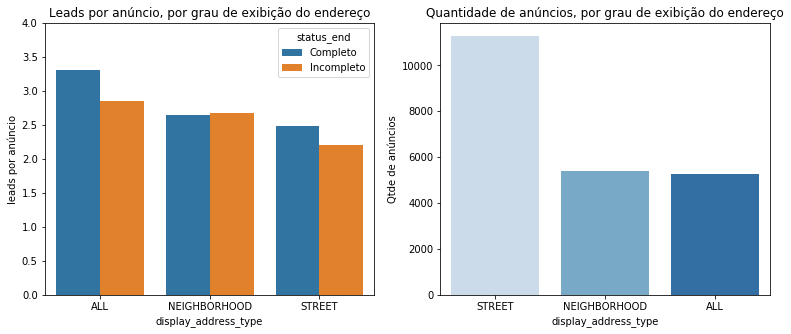

In [993]:
leads_por_anuncio_por_display_address_type =\
            listings[listings.status_lead != "0"]\
            .pivot_table(index= ['status_end','display_address_type'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'})

graf1 = round (leads_por_anuncio_por_display_address_type.leads / leads_por_anuncio_por_display_address_type.listing_id, 2).reset_index()
graf2 = listings.pivot_table (index='display_address_type', values= ['leads'], aggfunc= np.count_nonzero).sort_values('leads', ascending=False)

plt.figure (figsize=[13,5])

plt.subplot(121)
sns.barplot(data=graf1, x='display_address_type', y=0, hue='status_end')
plt.xticks (rotation = 'horizontal')
plt.ylim (0,4)
plt.ylabel ('leads por anúncio')
plt.title ('Leads por anúncio, por grau de exibição do endereço');

plt.subplot(122)
sns.barplot ( x=graf2.index, y= 'leads', data= graf2, palette='Blues')
plt.xticks (rotation = 'horizontal')
plt.ylabel ('Qtde de anúncios')
plt.title ('Quantidade de anúncios, por grau de exibição do endereço');

- Uma outra variável que influencia a quantidade de leads é o grau de exibição do endereço.
    - Anúncios com o endereço totalmente visível têm mais leads por anúncio que os demais.
    - Com excessão dos anúncios com visualização apenas do bairro, em todos os demais casos os anúncios com endereço completo apresentam melhor desempenho.
        - Contudo, mesmo nos anúncios com grau de visualização apenas do bairro, a taxa de anúncios com algum lead é maior nos anúncios com endereço completo (7,4 x 5,3)
- 85% de todos os leads aconteceu nos anúncios com endereço completo nos casos em que a exibição ia até a rua ou era completa.

#### Faixa de Preço

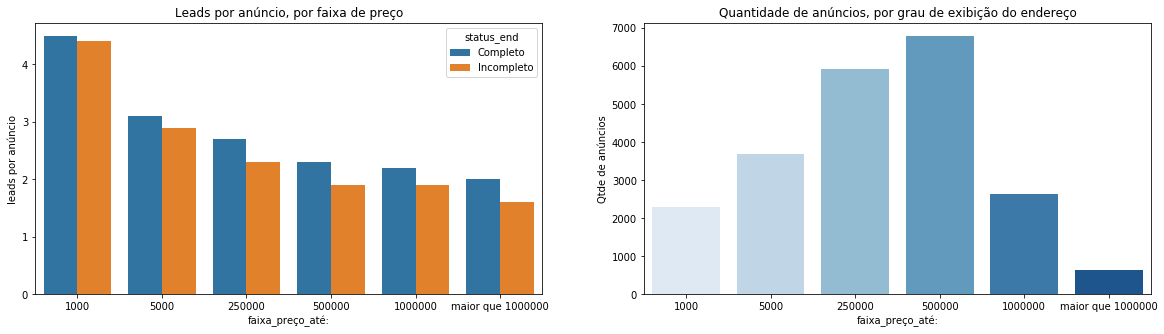

In [994]:
ref=[]
for i in listings.price:
    if i < 1000:
        ref.append (1000)
    elif i < 5000:
        ref.append (5000)
    elif i < 250000:
        ref.append (250000)
    elif i < 500000:
        ref.append (500000)
    elif i < 1000000:
        ref.append (1000000)
    else:
        ref.append("maior que 1000000")
listings ['faixa_preço_até:'] = ref

leads_por_anuncio_por_faixa_preço = listings[(listings.status_lead != "0") & (listings.city != '')]\
            .pivot_table(index= ['status_end','faixa_preço_até:'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'})

graf1 = round(leads_por_anuncio_por_faixa_preço.leads / leads_por_anuncio_por_faixa_preço.listing_id, 1).reset_index()
graf2 = listings[(listings.status_lead != "0")].pivot_table (index='faixa_preço_até:', values= ['listing_id'], aggfunc= 'count')


plt.figure (figsize=[20,5])

plt.subplot(121)
sns.barplot(data=graf1, x='faixa_preço_até:', y=0, hue='status_end')
plt.xticks (rotation = 'horizontal')
plt.ylabel ('leads por anúncio')
plt.title ('Leads por anúncio, por faixa de preço');

plt.subplot(122)
sns.barplot ( x=graf2.index, y= 'listing_id', data= graf2, palette='Blues')
plt.xticks (rotation = 'horizontal')
plt.ylabel ('Qtde de anúncios')
plt.title ('Quantidade de anúncios, por grau de exibição do endereço');

- O desempenho de leads por anúncio é inversamente proporcional a faixa de preços (graf1). Portanto, este é outra variável que impacta influencia a quantidade de leeds.
- Em ambos os casos, o desempenho de leads é melhor em anúncios com endereço completo.

#### Metros quadrados úteis da unidade 

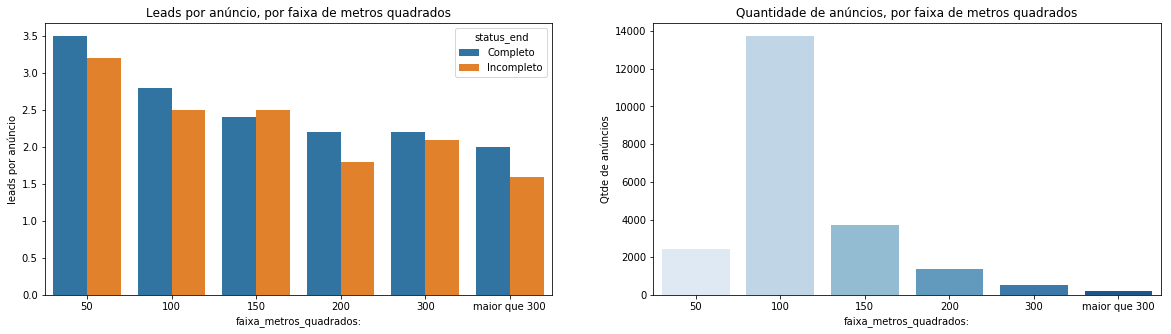

In [1002]:
ref=[]
for i in listings.usable_areas:
    if i < 50:
        ref.append (50)
    elif i < 100:
        ref.append (100)
    elif i < 150:
        ref.append (150)
    elif i < 200:
        ref.append (200)
    elif i < 300:
        ref.append (300)
    else:
        ref.append("maior que 300")
listings ['faixa_metros_quadrados:'] = ref

leads_por_anuncio_por_faixa_preço = listings[(listings.status_lead != "0") & (listings.usable_areas > 0)]\
            .pivot_table(index= ['status_end','faixa_metros_quadrados:'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'})

graf1 = round(leads_por_anuncio_por_faixa_preço.leads / leads_por_anuncio_por_faixa_preço.listing_id, 1).reset_index()
graf2 = listings[(listings.status_lead != "0")].pivot_table (index='faixa_metros_quadrados:', values= ['listing_id'], aggfunc= 'count')


plt.figure (figsize=[20,5])

plt.subplot(121)
sns.barplot(data=graf1, x='faixa_metros_quadrados:', y=0, hue='status_end')
plt.xticks (rotation = 'horizontal')
plt.ylabel ('leads por anúncio')
plt.title ('Leads por anúncio, por faixa de metros quadrados');

plt.subplot(122)
sns.barplot ( x=graf2.index, y= 'listing_id', data= graf2, palette='Blues')
plt.xticks (rotation = 'horizontal')
plt.ylabel ('Qtde de anúncios')
plt.title ('Quantidade de anúncios, por faixa de metros quadrados');

- O Tamanho da unidade também influencia a quantidade de leads (graf1). Talvez até mesmo pela demanda maior ser por unidades com tamanho entre 50 e 100 metros quadrados (graf2).
- Em quase todos os casos, o desempenho de leads é melhor em anúncios com endereço completo.
- Há alguns anúncios na base sem informação de metros quadrados (cerca de 60).

#### Idade do anúncio (em dias)

In [996]:
listings ['idade_anúncio'] = listings.snapshot_date - listings.created_date

ref=[]
for i in listings.idade_anúncio:
    if i < pd.to_timedelta (30, 'D'):
        ref.append ('até 30 dias')
    elif i <  pd.to_timedelta (90, 'D'):
        ref.append ('de 30 a 90 dias')
    elif i <  pd.to_timedelta (180, 'D'):
        ref.append ('de 90 a 180 dias')
    elif i <  pd.to_timedelta (360, 'D'):
        ref.append ('de 180 a 360 dias')
    elif i <  pd.to_timedelta (680, 'D'):
        ref.append ('de 360 a 680 dias')
    else:
        ref.append("mais de 680 dias")
listings ['faixa_idade_anúncio'] = ref

leads_por_anuncio_por_idade_do_anúncio = listings[(listings.status_lead != "0") & (listings.city != '')]\
            .pivot_table(index= ['status_end','faixa_idade_anúncio'], values= ['listing_id', 'leads'],
                         aggfunc= {'listing_id': 'count', 'leads': 'sum'})

graf1 = round(leads_por_anuncio_por_idade_do_anúncio.leads / leads_por_anuncio_por_idade_do_anúncio.listing_id, 1).reset_index()
graf2 = listings[(listings.status_lead != "0")].pivot_table (index='faixa_idade_anúncio', values= ['listing_id'], aggfunc= 'count')


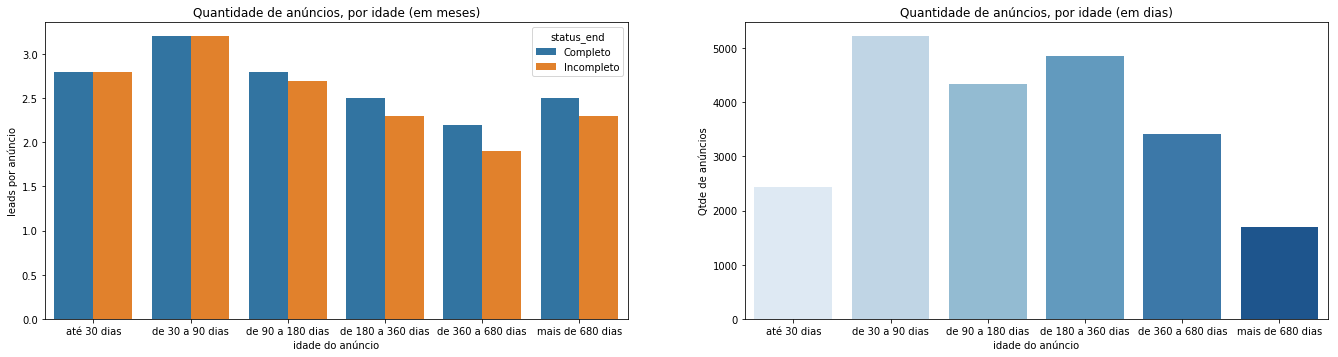

In [997]:
plt.figure (figsize=[23,12])

order =  ['até 30 dias', 'de 30 a 90 dias', 'de 90 a 180 dias', 'de 180 a 360 dias', 'de 360 a 680 dias', 'mais de 680 dias']

plt.subplot(221)
sns.barplot(data=graf1, x='faixa_idade_anúncio', y=0, hue='status_end', order= order)
plt.xticks (rotation = 'horizontal')
plt.ylabel ('leads por anúncio')
plt.xlabel ('idade do anúncio')
plt.title ('Quantidade de anúncios, por idade (em meses)');

plt.subplot(222)
sns.barplot ( x=graf2.index, y= 'listing_id', data= graf2, palette='Blues', order= order)
plt.xticks (rotation = 'horizontal')
plt.ylabel ('Qtde de anúncios')
plt.xlabel ('idade do anúncio')
plt.title ('Quantidade de anúncios, por idade (em dias)');

- A idade do anúncio não parece influenciar no seu desempenho. O que pode fazer concluir que não é pelo maior tempo em exposição no site que fará o anúncio ter mais leads.
- Também não é possível dizer que dependendo da idade, o anúncio com endereço incompleto terá melhor desempenho. Em praticamente todos os casos (graf1), os anúncios com endereço completo tem melhor desempenho.

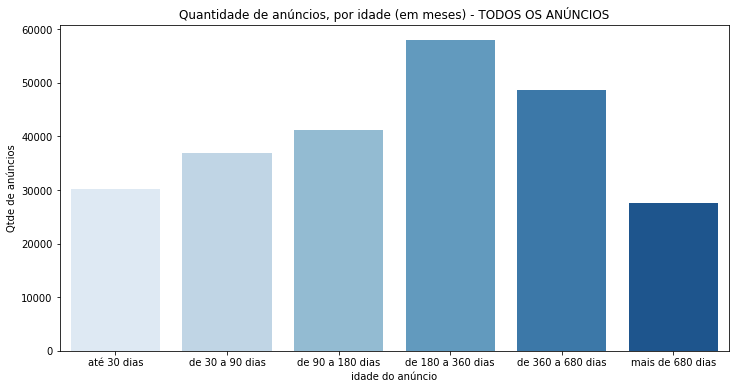

In [998]:
graf3 = listings[(listings.status_lead != "")].pivot_table (index='faixa_idade_anúncio', values= ['listing_id'], aggfunc= 'count')

plt.figure (figsize=[12, 6])

plt.subplot(111)
sns.barplot ( x=graf3.index, y= 'listing_id', data= graf3, palette='Blues', order= order)
plt.xticks (rotation = 'horizontal')
plt.ylabel ('Qtde de anúncios')
plt.xlabel ('idade do anúncio')
plt.title ('Quantidade de anúncios, por idade (em meses) - TODOS OS ANÚNCIOS');

### Conclusão:

1. De fato anúncios com endereço incompleto possuem um melhor desempenho?
<font color="blue">     Com base nas análises acima, anúncios com endereço incompleto NÃO possuem um melhor desempenho.

2. Ressalvas e problemas nos dados que prejudicaram a análise.
<font color="blue"> Não vi problema relevante nos dados que prejudicassem a análise. 

3. Próximos passos que você vislumbra para esse estudo.
<font color="blue"> Confirmar se as conclusões deste estudo se aplicam também em outras cidades.